In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.cross_decomposition import CCA
import plotly.express as px
import plotly.graph_objects as go
import ast
import joblib
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv('df_season_clean_agg_multnat.csv')

In [ ]:
df.columns

Index(['Player', 'Season', 'ID', 'Position', 'Nationality', 'Market Value',
       'Club', 'Age', 'days_injured', 'injuries', 'games_missed',
       'appearances', 'own_goals', 'assists', 'substitutions_on',
       'substitutions_off', 'second_yellow_cards', 'red_cards',
       'penalty_goals', 'minutes_per_goal', 'minutes_played', 'goals',
       'yellow_cards', 'mean_goals', 'goals_diff', 'Market_Value_normalizada'],
      dtype='object')

In [ ]:
df = pd.get_dummies(df, columns=['Club'], drop_first=True)
df = pd.get_dummies(df, columns=['Position'], drop_first=True)
# Convert the string representation of lists into actual Python lists
df['Nationality'] = df['Nationality'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Apply MultiLabelBinarizer to directly transform the list of nationalities into separate columns
mlb = MultiLabelBinarizer()

# Apply MultiLabelBinarizer to the now correctly formatted list column
nationality_encoded = mlb.fit_transform(df['Nationality'])

# Create a DataFrame with the encoded nationality columns
nationality_df = pd.DataFrame(nationality_encoded, columns=mlb.classes_)
nationality_df.columns = ['Nationality_' + col for col in nationality_df.columns]

# Concatenate the new nationality columns with the existing DataFrame and drop the original 'Nationality' column
df = pd.concat([df.drop('Nationality', axis=1), nationality_df], axis=1)

In [ ]:
# prompt: display ALL cols, no turncation

pd.set_option("display.max_rows", None, "display.max_columns", None)
df.head()

,Player,Season,ID,Market Value,Age,days_injured,injuries,games_missed,appearances,own_goals,assists,substitutions_on,substitutions_off,second_yellow_cards,red_cards,penalty_goals,minutes_per_goal,minutes_played,goals,yellow_cards,mean_goals,goals_diff,Market_Value_normalizada,Club_1.FC Union Berlin,Club_AA Argentinos Juniors,Club_AC Milan,Club_AC Perugia Calcio,Club_AC Sparta Prague,Club_ACF Fiorentina,Club_ADO Den Haag,Club_AFC Bournemouth,Club_AIK,Club_AS Monaco,Club_AS Monaco B,Club_AS Monaco U19,Club_AS Roma,Club_AS Saint-Étienne,Club_AZ Alkmaar,Club_Aberdeen FC,Club_Ajax Amsterdam,Club_Ajax Amsterdam U21,Club_Amiens SC,Club_América Futebol Clube (MG),Club_Angers SCO,Club_Arsenal FC,Club_Ascoli Calcio,Club_Aston Villa,Club_Atalanta BC,Club_Atalanta Primavera,Club_Athletic Bilbao,Club_Atlético Mineiro U20,Club_Atlético Paranaense,Club_Atlético de Madrid,Club_Avaí FC,Club_Avispa Fukuoka,Club_Barnsley FC,Club_Barnsley FC U18,Club_Barranquilla FC,Club_Bayer 04 Leverkusen,Club_Bayern Munich,Club_Beerschot VA,Club_Beijing Guoan,Club_Bilbao Athletic,Club_Birmingham City,Club_Blackburn Rovers,Club_Bologna FC 1909,Club_Borussia Dortmund,Club_Borussia Mönchengladbach,Club_Brentford FC,Club_Brescia Calcio,Club_Brighton & Hove Albion,Club_Brighton & Hove Albion U23,Club_Bryne FK,Club_Burnley FC,Club_CA Belgrano II,Club_CA Boca Juniors,Club_CA Boston River,Club_CA Fénix,Club_CA Osasuna,Club_CA Peñarol,Club_CA Rentistas,Club_CA River Plate,Club_CA River Plate II,Club_CD Cruz Azul,Club_CD Cruz Azul U20,Club_CD Mafra,Club_CD Mirandés,Club_CF América,Club_CF América U20,Club_CR Flamengo,Club_Cagliari Calcio,Club_Cagliari Primavera,Club_Carpi FC 1909,Club_Celta Vigo B,Club_Celta de Vigo,Club_Celtic FC,Club_Charlton Athletic,Club_Chelsea FC,Club_Chelsea FC U18,Club_Chelsea FC U23,Club_Chicago Fire FC,Club_Club Athletico Paranaense,Club_Club Atlético Belgrano,Club_Club Brugge KV,Club_Clube Atlético Mineiro,Club_Coventry City,Club_Cruzeiro Esporte Clube,Club_Crystal Palace,Club_Defensa y Justicia,Club_Deportivo Alavés,Club_Deportivo de La Coruña,Club_Derby County,Club_Desportivo Brasil Ltda (SP),Club_Dijon FCO,Club_Dinamo Tbilisi,Club_Dnipro Dnipropetrovsk (-2020),Club_EA Guingamp,Club_ESTAC Troyes,Club_ESTAC Troyes B,Club_Eintracht Frankfurt,Club_El Mokawloon SC,Club_Elche CF,Club_Empoli FC,Club_Envigado FC,Club_Everton FC,Club_Everton FC U23,Club_Excelsior Rotterdam,Club_Exeter City,Club_FC Admira Wacker Mödling,Club_FC Barcelona,Club_FC Barcelona Atlètic,Club_FC Barcelona B,Club_FC Barcelona U19,Club_FC Basel 1893,Club_FC Bayern Munich II,Club_FC Copenhagen,Club_FC Copenhagen U19,Club_FC Crotone,Club_FC Empoli,Club_FC Girondins Bordeaux,Club_FC Liefering,Club_FC Locomotive Tbilisi,Club_FC Metz,Club_FC Midtjylland,Club_FC Nantes,Club_FC Nordsjaelland,Club_FC Paços de Ferreira,Club_FC Paços de Ferreira U19,Club_FC Porto,Club_FC Porto B,Club_FC Porto U19,Club_FC Rustavi,Club_FC Schalke 04,Club_FC Schalke 04 U19,Club_FC Sion,Club_FC Sochaux-Montbéliard,Club_FC St. Pauli,Club_FC Tokyo,Club_FC Tokyo U18,Club_FC Toulouse,Club_FC Twente Enschede U21,Club_FC Ufa,Club_FC Utrecht,Club_FC Volendam,Club_FC Winterthur,Club_FK Bodø/Glimt,Club_FK Partizan Belgrade,Club_FUS Rabat,Club_Fenerbahce,Club_Feyenoord Rotterdam,Club_Fluminense Football Club,Club_Fortaleza Esporte Clube,Club_Fulham FC,Club_GNK Dinamo Zagreb,Club_Galatasaray,Club_Genoa CFC,Club_Getafe CF,Club_Girona FC,Club_Hamburger SV,Club_Hellas Verona,Club_Hertha BSC,Club_Huddersfield Town,Club_Hull City,Club_IF Brommapojkarna,Club_Independiente del Valle,Club_Inter Milan,Club_Inter Milan Primavera,Club_Jeonbuk Hyundai Motors,Club_Junior FC,Club_Juventus FC,Club_KAA Gent,Club_KRC Genk,Club_Karlsruher SC,Club_Kawasaki Frontale,Club_LOSC Lille,Club_LOSC Lille B,Club_Leeds United,Club_Leicester City,Club_Linares Deportivo,Club_Liverpool FC,Club_Liverpool FC U23,Club_MSK Zilina,Club_Manchester City,Club_Manchester City U23,Club_Manchester United,Club_Manchester United U21,Club_Milan Primavera,Club_Mi

In [ ]:
X = df.drop(['Player', 'Season', 'Market Value', 'Market_Value_normalizada'], axis=1)
y = df['Market_Value_normalizada']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.shape

(1750, 398)

### PCA

In [ ]:
df_pca = pd.read_csv('df_season_clean_agg.csv')
df_pca = df_pca.drop(['ID'], axis=1)
df_pca.columns

Index(['Player', 'Season', 'Position', 'Nationality', 'Market Value', 'Club',
       'Age', 'days_injured', 'injuries', 'games_missed', 'appearances',
       'own_goals', 'assists', 'substitutions_on', 'substitutions_off',
       'second_yellow_cards', 'red_cards', 'penalty_goals', 'minutes_per_goal',
       'minutes_played', 'goals', 'yellow_cards', 'mean_goals', 'goals_diff',
       'Market_Value_normalizada'],
      dtype='object')

In [ ]:
# Group by player to calculate career stats
df_player = (
    df_pca.groupby('Player').agg({
        'Market Value': 'mean',
        'Club': lambda x: x.loc[x.idxmax()],
        'Age': lambda x: x.loc[x.idxmax()],
        'days_injured': 'sum',
        'injuries': 'sum',
        'games_missed': 'sum',
        'appearances': 'sum',
        'own_goals': 'sum',
        'assists': 'sum',
        'substitutions_on': 'sum',
        'substitutions_off': 'sum',
        'second_yellow_cards': 'sum',
        'red_cards': 'sum',
        'penalty_goals': 'sum',
        'minutes_per_goal': 'mean',
        'minutes_played': 'sum',
        'goals': 'sum',
        'yellow_cards': 'sum',
    })
    .reset_index()
)

# List of columns to scale (numerical columns)
columns_to_scale = [
    'Market Value', 'Age', 'days_injured', 'injuries', 'games_missed',
    'appearances', 'own_goals', 'assists', 'substitutions_on', 'substitutions_off',
    'second_yellow_cards', 'red_cards', 'penalty_goals', 'minutes_per_goal',
    'minutes_played', 'goals', 'yellow_cards'
]

scaler = StandardScaler()

df_player[columns_to_scale] = scaler.fit_transform(df_player[columns_to_scale])

display(df_player)

,Player,Market Value,Club,Age,days_injured,injuries,games_missed,appearances,own_goals,assists,substitutions_on,substitutions_off,second_yellow_cards,red_cards,penalty_goals,minutes_per_goal,minutes_played,goals,yellow_cards
0,Achraf Hakimi,0.746328,Real Madrid Castilla,0.383141,-0.496513,-0.338143,-0.675541,0.556114,0.553814,0.906943,-0.080924,-0.402568,1.454662,2.526242,-0.490150,1.234492,0.606722,-0.153533,0.875948
1,Ademola Lookman,-0.815503,RB Leipzig,0.718055,-0.256635,0.250957,-0.300625,0.459664,-0.479421,0.191586,2.201558,0.932687,-0.776414,-0.668836,-0.102782,-0.252835,0.038843,0.448716,-0.370362
2,Alan Varela,-1.048620,FC Porto,-0.621600,-1.104574,-1.074518,-1.050457,-0.680201,-0.479421,-0.783901,-0.599670,-0.470462,0.339124,-0.668836,-0.490150,-0.564647,-0.081512,-0.816007,0.408582
3,Alejandro Balde,-0.651079,FC Barcelona U19,-1.291427,1.126844,0.103682,0.622245,-1.013392,0.553814,-0.686353,-0.634253,-0.855197,-0.776414,-0.668836,-0.490150,-1.716008,-0.922264,-0.856157,-0.941587
4,Alejandro Garnacho,0.299625,Manchester United,-1.291427,-0.847961,-1.074518,-0.704381,-1.039697,-0.479421,-0.523772,-0.184674,-0.470462,-0.776414,-0.668836,-0.490150,2.154270,-0.447417,-0.414508,-0.941587
5,Alejandro Grimaldo,-0.732263,SL Benfica,1.387882,2.867350,1.134606,3.967650,1.932719,0.553814,2.207592,-0.634253,0.208481,0.339124,-0.668836,-0.231904,0.325469,2.228740,0.007066,1.083666
6,Aleksandar Pavlovic,0.388753,FC Bayern Munich II,-1.291427,-0.574613,-0.190868,-0.589022,-1.679775,-0.479421,-0.881450,-1.325915,-1.104143,-0.776414,-0.668836,-0.490150,0.426136,-1.365293,-0.836082,-1.045446
7,Alessandro Bastoni,0.393705,Parma Calcio 1913,0.048228,-0.278950,0.987331,-0.127587,0.310604,-0.479421,-0.393707,-0.634253,0.163218,1.454662,-0.668836,-0.490150,-0.754173,0.320361,-0.675482,0.512441
8,Alessandro Buongiorno,-1.284881,Trapani Calcio,0.048228,-0.490934,-0.190868,-0.444823,-0.539910,-0.479421,-0.751385,-0.738003,-0.877828,0.339124,-0.668836,-0.490150,-1.062301,-0.748649,-0.755782,0.097004
9,Alexander Isak,0.004652,Real Sociedad,0.048228,0.429526,0.545506,0.593406,0.196618,-0.479421,-0.231125,0.679903,1.317421,-0.776414,-0.668836,1.317568,-0.332517,-0.097075,1.151339,-0.370362


In [ ]:
# Extract the mean and standard deviation used during scaling
market_value_mean = scaler.mean_[columns_to_scale.index('Market Value')]
market_value_std = scaler.scale_[columns_to_scale.index('Market Value')]

# Function to unscale and format market value
def format_market_value(value):
    # Unscale the value
    unscaled_value = (value * market_value_std) + market_value_mean

    # Format the unscaled value
    if unscaled_value >= 1_000_000:
        return f"{unscaled_value / 1_000_000:.1f}m"
    elif unscaled_value >= 1_000:
        return f"{unscaled_value / 1_000:.0f}k"
    else:
        return str(unscaled_value)

In [ ]:
stats_without_market_value = df_player.drop(columns=['Market Value', 'Club', 'Player'])
market_values = df_player['Market Value']

# Perform PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(stats_without_market_value.fillna(0))  # Fill NA values if necessary

# Create a DataFrame for PCA components
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Market Value'] = market_values

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['Market Value'] = market_values

# Apply logarithmic scaling to Market Value for better visualization
def scale_market_value(values):
    return np.log1p(values)

pca_df['Scaled Market Value'] = scale_market_value(pca_df['Market Value'])
pca_df['Player'] = df_player['Player'].values
pca_df['Formatted Market Value'] = pca_df['Market Value'].apply(format_market_value)

# Create interactive scatter plot
fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='Scaled Market Value',
    title="PCA Plot with Scaled Market Value Heatmap",
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
    color_continuous_scale='viridis',
    hover_data={'Player': True, 'Formatted Market Value': True}
)

# Customize hover behavior to include formatted unscaled market value
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')),
    hovertemplate=(
        '<b>%{customdata[0]}</b><br>'
        'Av. Market Value: %{customdata[1]}<br>'
    )
)

fig.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log1p



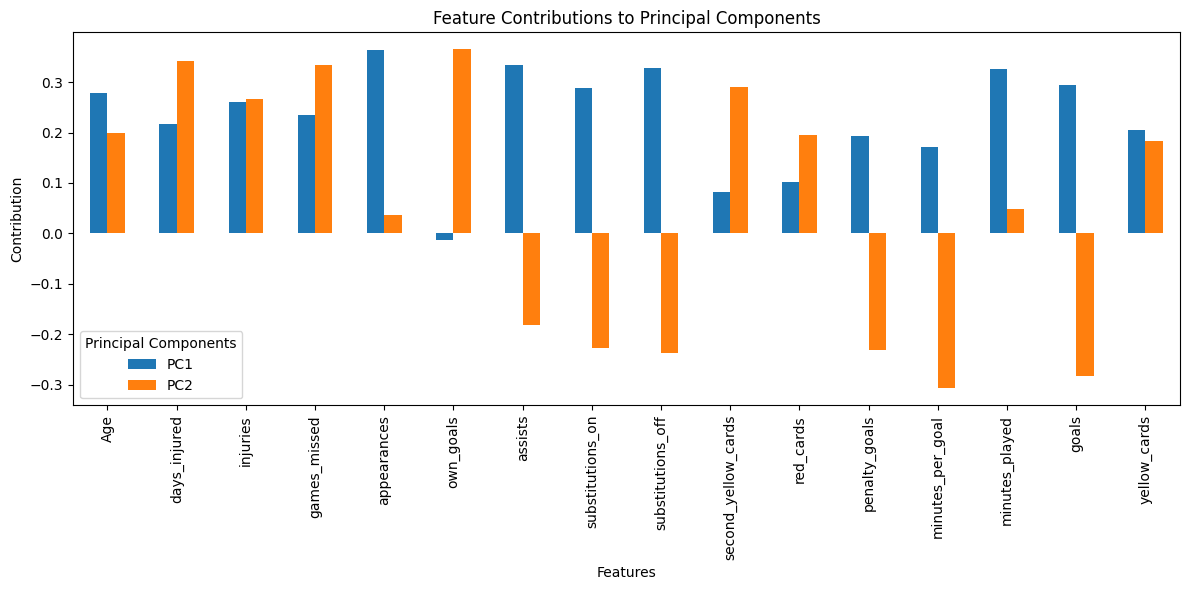

In [ ]:
# Plot feature contributions to PCA components
feature_contributions = pd.DataFrame(pca.components_, columns=stats_without_market_value.columns, index=['PC1', 'PC2'])

# Bar plot for each principal component
feature_contributions.T.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Contributions to Principal Components')
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.legend(title='Principal Components')
plt.tight_layout()
plt.show()


In [ ]:
pca.explained_variance_ratio_

array([0.38623779, 0.14456481])

In [ ]:
# Prepare data for CCA
stats_without_market_value = df_player.drop(columns=['Market Value', 'Club', 'Player'])
market_values = df_player[['Market Value']]

# Perform CCA
cca = CCA(n_components=1)  # Adjusted to n_components=1 as per the error
cca_components_X, cca_components_Y = cca.fit_transform(stats_without_market_value.fillna(0), market_values)

# Prepare the dataframe for Plotly
cca_df = pd.DataFrame(cca_components_X, columns=['CCA1'])
cca_df['Market Value'] = market_values.values.flatten()
cca_df['Player'] = df_player['Player'].values
cca_df['Formatted Market Value'] = cca_df['Market Value'].apply(format_market_value)

# Create interactive scatter plot
fig = px.scatter(
    cca_df,
    x='CCA1',
    y='Market Value',
    title="CCA Plot",
    labels={'CCA1': 'Canonical Component 1', 'Market Value': 'Market Value'}
)

# Customize hover behavior to display player names and unscaled market value
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color='DarkSlateGrey')),
    hovertemplate=(
        '<b>%{customdata[0]}</b><br>'
        'CCA1: %{x}<br>'
        'Market Value: %{customdata[1]}'
    ),
    customdata=cca_df[['Player', 'Formatted Market Value']].values
)

x_values = np.linspace(cca_df['CCA1'].min(), cca_df['CCA1'].max(), 100)
y_values = x_values

fig.add_trace(go.Scatter(
    x=x_values,
    y=y_values,
    mode='lines',
    name='y = x',
    line=dict(color='red', dash='dash')
))

fig.show()

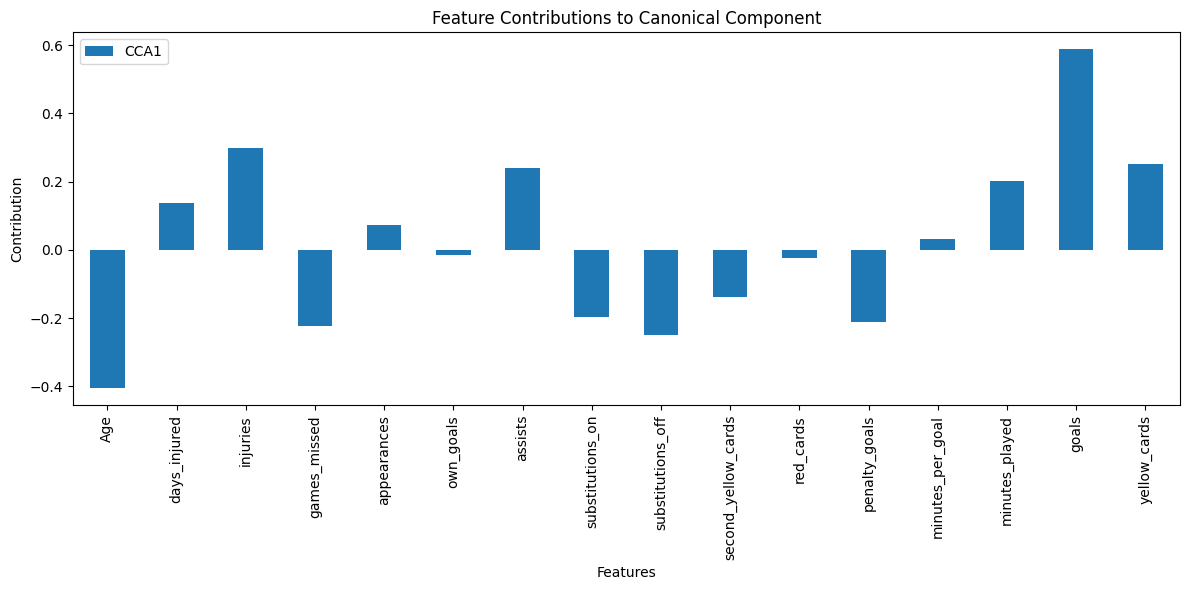

In [ ]:
# Plot feature contributions to CCA component
feature_contributions = pd.DataFrame(cca.x_weights_, index=stats_without_market_value.columns, columns=['CCA1'])

# Bar plot for the canonical component
feature_contributions.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Contributions to Canonical Component')
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.tight_layout()
plt.show()


In [ ]:
correlation = cca_df['CCA1'].corr(cca_df['Market Value'])

print(f"Corr: {correlation}")

Corr: 0.6276430524918245


# Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))


print(f"MSE: {rmse_rf}")
print(f"R2: {r2_rf}")

Fitting 3 folds for each of 486 candidates, totalling 1458 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
486 fits failed out of a total of 1458.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Mejores parámetros: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
MSE: 0.09317767448625616
R2: 0.5890036797601026


In [ ]:
def plot_feature_importances(best_model):
  feature_importances = best_model.feature_importances_
  features = X_train.columns

  sorted_idx = np.argsort(feature_importances)

  top_5_idx = sorted_idx[-10:]
  top_5_features = np.array(features)[top_5_idx]
  top_5_importances = feature_importances[top_5_idx]

  plt.figure(figsize=(10, 6))
  plt.barh(range(len(top_5_features)), top_5_importances, align='center', color='skyblue')
  plt.yticks(range(len(top_5_features)), top_5_features)
  plt.xlabel("Importancia")
  plt.title("Top 10 Importancia de las Características")
  plt.show()

In [ ]:
def plot_real_vs_pred(y_test, y_pred):
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred, alpha=0.6, color="blue")
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')
  plt.title("Real vs. Predicho")
  plt.xlabel("Valores Reales")
  plt.ylabel("Predicciones")
  plt.show()


In [ ]:
def plot_learning_curve(best_model, X_train):
  train_sizes, train_scores, test_scores = learning_curve(
      best_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
  )

  train_mean = -np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = -np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  plt.figure(figsize=(10, 6))
  plt.plot(train_sizes, train_mean, label="Training Error", color="blue")
  plt.plot(train_sizes, test_mean, label="Validation Error", color="orange")

  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="orange")

  plt.title("Curva de Aprendizaje")
  plt.xlabel("Número de Muestras de Entrenamiento")
  plt.ylabel("Error (MSE)")
  plt.legend(loc="best")
  plt.show()


In [ ]:
def plot_residuals(y_test, y_pred):
  errors = y_test - y_pred
  plt.figure(figsize=(8, 6))
  plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
  plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
  plt.title("Distribución de Errores (Residuos)")
  plt.xlabel("Error")
  plt.ylabel("Frecuencia")
  plt.show()



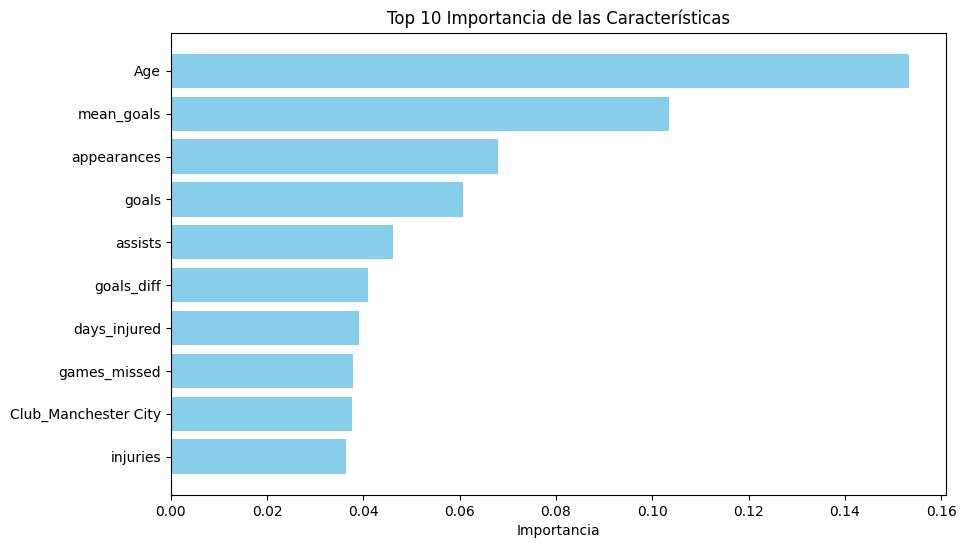

In [ ]:
plot_feature_importances(best_model)

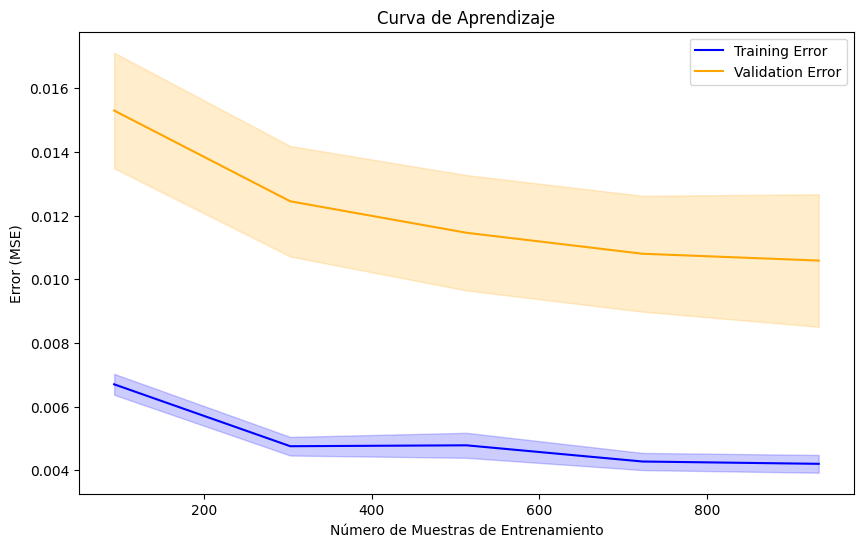

In [ ]:
plot_learning_curve(best_model, X_train)

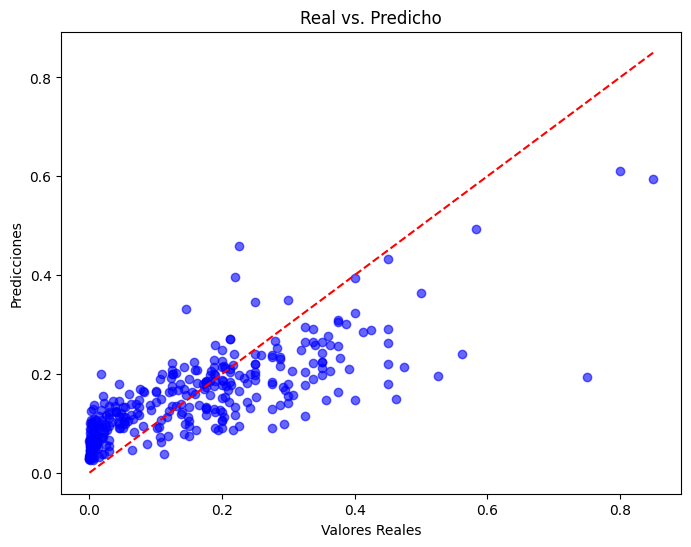

In [ ]:
plot_real_vs_pred(y_test, y_pred)

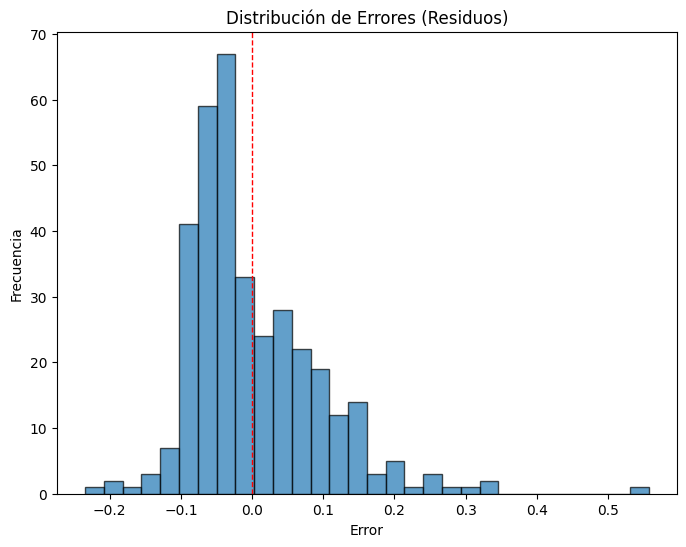

In [ ]:
plot_residuals(y_test, y_pred)

In [ ]:
# Save the model to a file
joblib.dump(best_model, 'rf_model.pkl')

['rf_model.pkl']

# XGBoost

In [ ]:
xgb_model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_child_weight': [5, 10],
    'lambda': [0.1, 1, 10],
    'alpha': [0.1, 1, 10],
    'colsample_bytree': [0.8, 1.0]
}

def rmse_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=make_scorer(rmse_scorer, greater_is_better=False),  # Negative RMSE for minimization
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_xgb = r2_score(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Test Set RMSE:", rmse_xgb)
print("Test Set R²:", r2_xgb)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best Parameters: {'alpha': 0.1, 'colsample_bytree': 0.8, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.8}
Test Set RMSE: 0.07880449786429419
Test Set R²: 0.7060210656162114


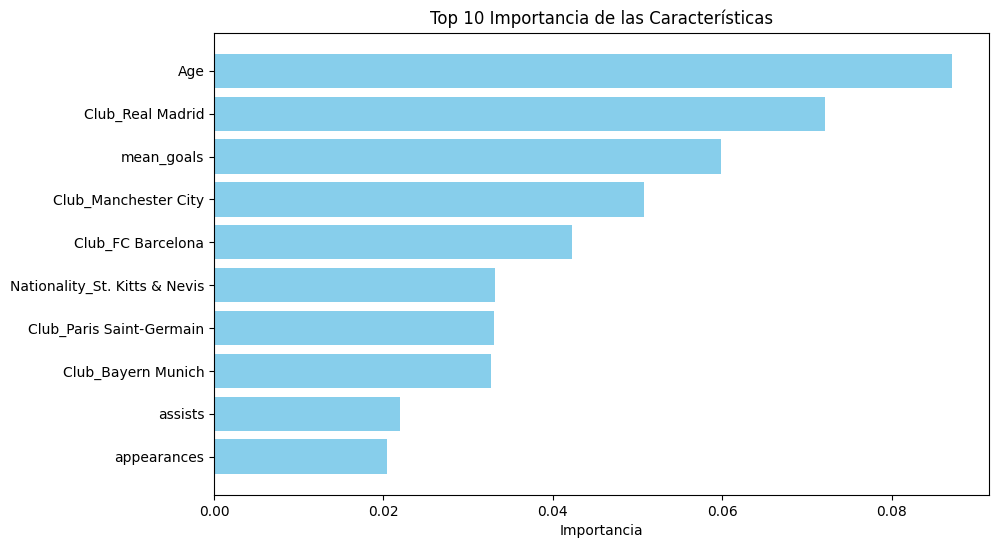

In [ ]:
plot_feature_importances(best_model)

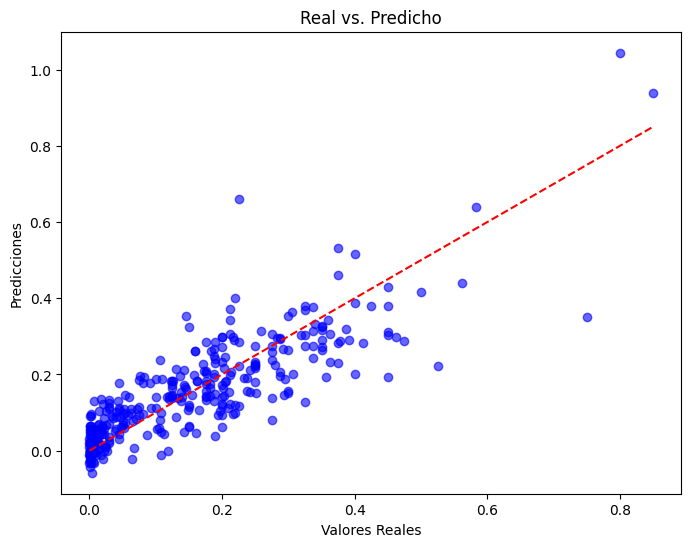

In [ ]:
plot_real_vs_pred(y_test, y_pred_best)

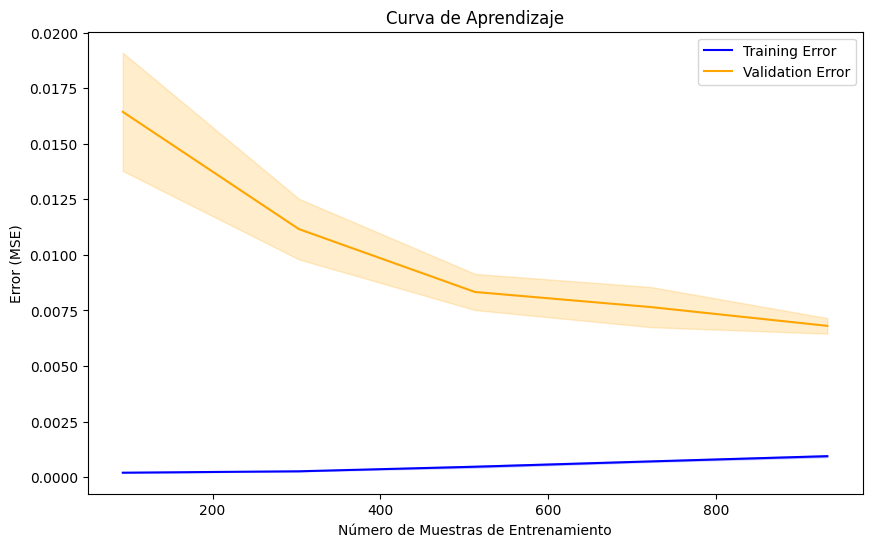

In [ ]:
plot_learning_curve(best_model, X_train)

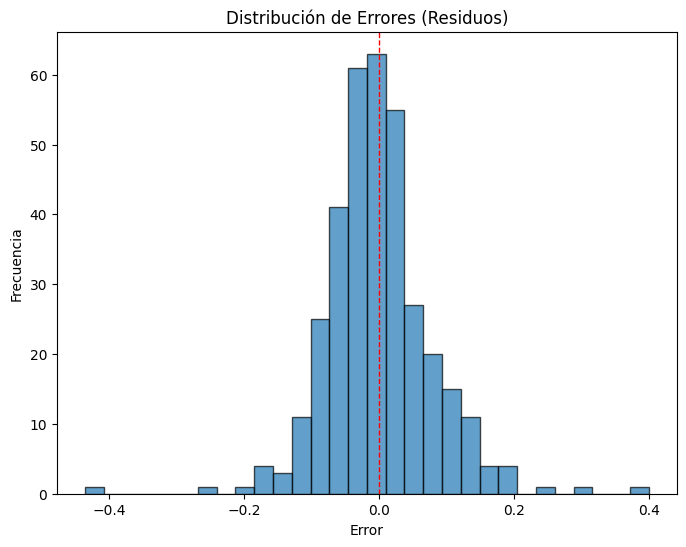

In [ ]:
plot_residuals(y_test, y_pred_best)

In [ ]:
xgb_model = best_model
joblib.dump(best_model, 'xgb_model.pkl')


['xgb_model.pkl']

# Light GBM

In [ ]:
df.columns

Index(['Player', 'Season', 'ID', 'Market Value', 'Age', 'days_injured',
       'injuries', 'games_missed', 'appearances', 'own_goals',
       ...
       'Suriname', 'Sweden', 'Switzerland', 'The Gambia', 'Togo', 'Türkiye',
       'Ukraine', 'United States', 'Uruguay', 'Wales'],
      dtype='object', length=402)

In [ ]:
import re
X_train_lgb = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 31, 50],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_lgb, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

best_lgb_model = grid_search.best_estimator_
y_pred_lgb = best_lgb_model.predict(X_test)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)
print("LightGBM - RMSE:", rmse_lgb)
print("LightGBM - R²:", r2_lgb)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1439
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 102
[LightGBM] [Info] Start training from score 0.144348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

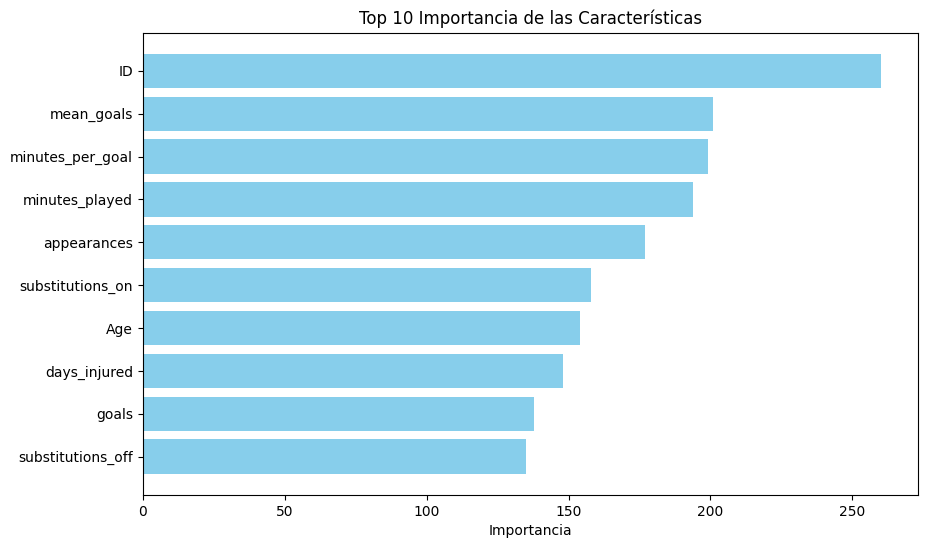

In [ ]:
plot_feature_importances(best_lgb_model)

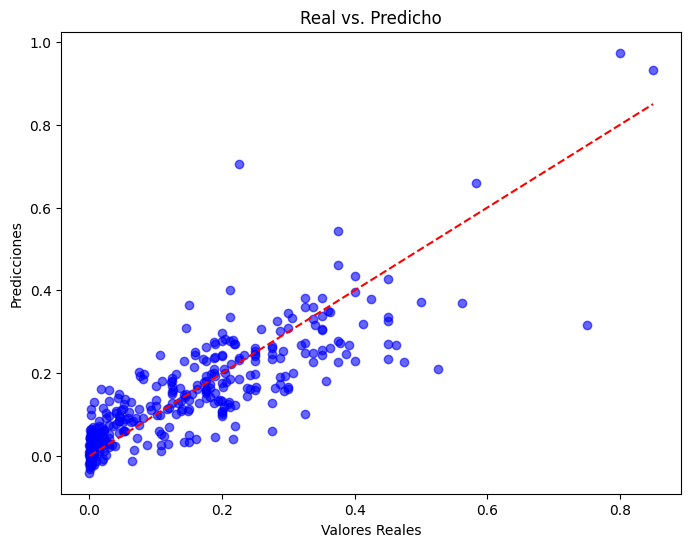

In [ ]:
plot_real_vs_pred(y_test, y_pred_lgb)

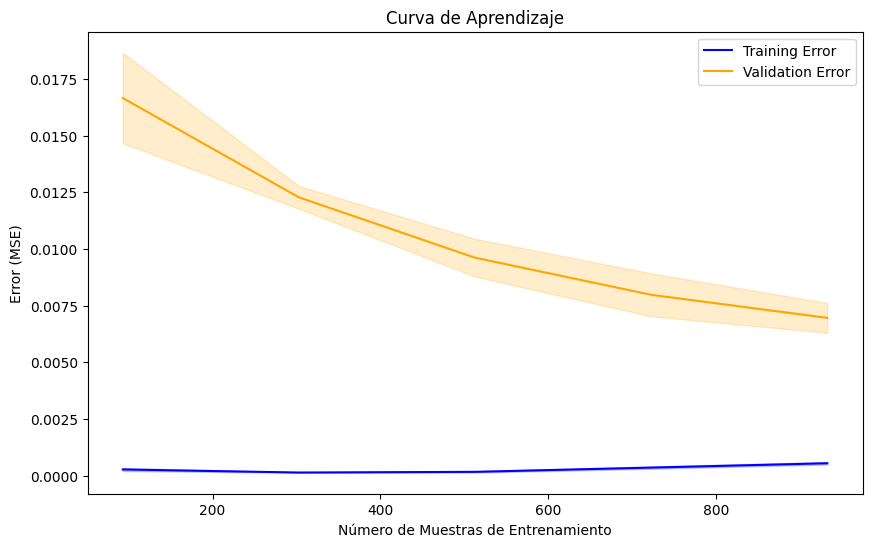

In [ ]:
plot_learning_curve(best_lgb_model, X_train_lgb)

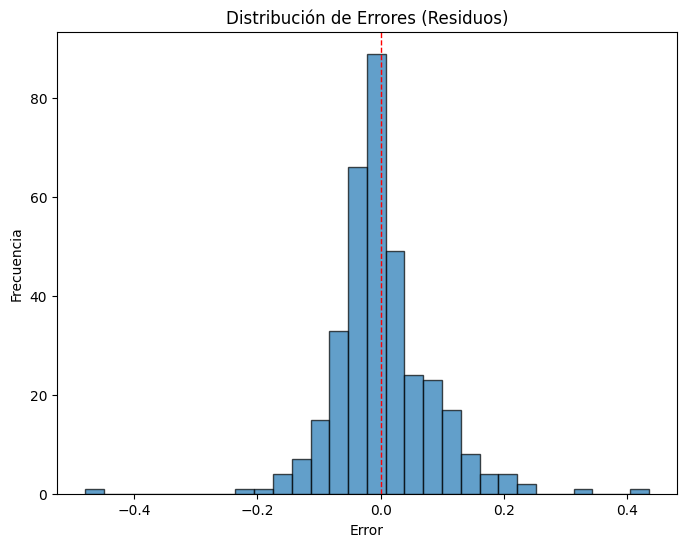

In [ ]:
plot_residuals(y_test, y_pred_lgb)

In [ ]:
joblib.dump(best_lgb_model, 'lgb_model.pkl')


['lgb_model.pkl']

# Ensemble

In [ ]:
lgb_model = joblib.load('lgb_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
rf_model = joblib.load('rf_model.pkl')

y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb = lgb_model.predict(X_test)

y_pred_ensemble = (y_pred_xgb + y_pred_rf + y_pred_lgb) / 3

rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
r2_ensemble = r2_score(y_test, y_pred_ensemble)
print("Ensemble - RMSE:", rmse_ensemble)
print("Ensemble - R²:", r2_ensemble)

Ensemble - RMSE: 0.07855489456168298
Ensemble - R²: 0.7078803986986948


### Staking ensemble

In [ ]:
from sklearn.linear_model import LinearRegression

y_stack_rf = rf_model.predict(X_train)
y_stack_xgb = xgb_model.predict(X_train)
y_stack_lgb = lgb_model.predict(X_train)

stacked_features = np.column_stack((y_stack_xgb, y_stack_rf, y_stack_lgb))

meta_model = LinearRegression()

X_train_stack, X_val_stack, y_train_stack, y_val_stack = train_test_split(
    stacked_features, y_train, test_size=0.2, random_state=42
)

meta_model.fit(X_train_stack, y_train_stack)

stacked_test_features = np.column_stack((
    y_pred_xgb, y_pred_rf, y_pred_lgb
))

y_pred_stack = meta_model.predict(stacked_test_features)

rmse_stack = np.sqrt(mean_squared_error(y_test, y_pred_stack))
r2_stack = r2_score(y_test, y_pred_stack)

print("Stacked Ensemble - RMSE:", rmse_stack)
print("Stacked Ensemble - R²:", r2_stack)


Stacked Ensemble - RMSE: 0.0831276023285475
Stacked Ensemble - R²: 0.6728818001738415


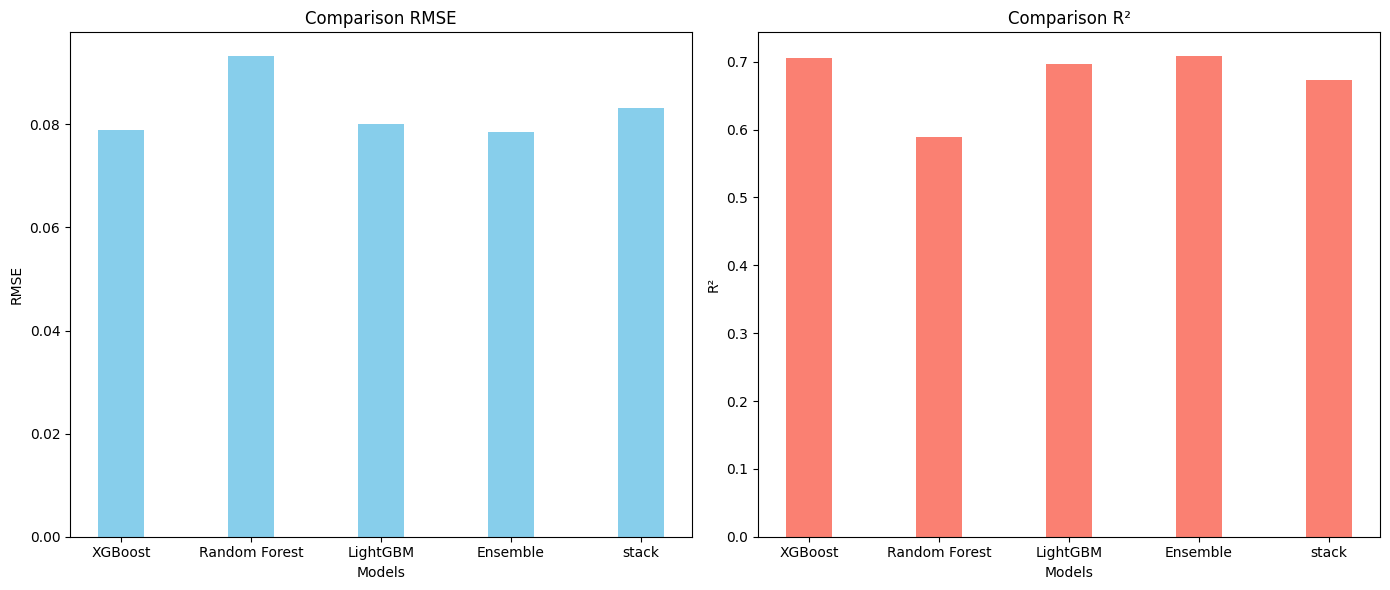

In [ ]:
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
r2_lgb = r2_score(y_test, y_pred_lgb)


model_names = ['XGBoost', 'Random Forest', 'LightGBM', 'Ensemble', 'stack']
rmse_values = [rmse_xgb, rmse_rf, rmse_lgb, rmse_ensemble, rmse_stack]
r2_values = [r2_xgb, r2_rf, r2_lgb, r2_ensemble, r2_stack]

x = np.arange(len(model_names))

width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].bar(x, rmse_values, width, color='skyblue', label='RMSE')
ax[0].set_xlabel('Models')
ax[0].set_ylabel('RMSE')
ax[0].set_title('Comparison RMSE')
ax[0].set_xticks(x)
ax[0].set_xticklabels(model_names)

ax[1].bar(x, r2_values, width, color='salmon', label='R²')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('R²')
ax[1].set_title('Comparison R²')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_names)

plt.tight_layout()
plt.show()


# Reduced dataset

Reduce the dataset dimension for the application part by only taking important clubs and narionalities for the model selected (XGBoost)

In [ ]:
rf_model = joblib.load('xgb_model.pkl')

<Figure size 1200x800 with 0 Axes>

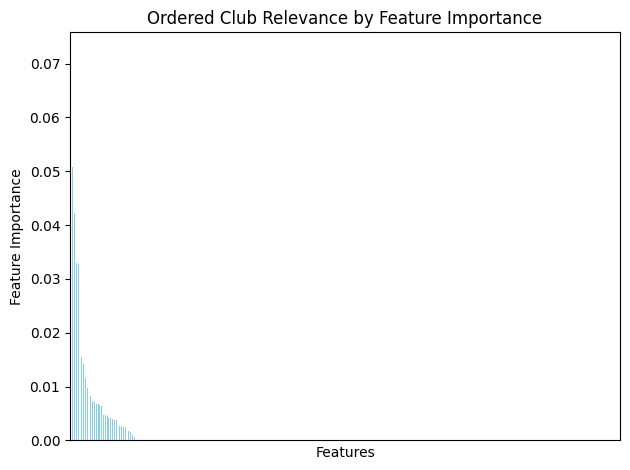

In [ ]:
feature_importances = rf_model.feature_importances_

features = X.columns
importance_df = pd.DataFrame({
    'Features': features,
    'Importance': feature_importances
})

# Filter only the club columns for relevance
club_columns = [col for col in features if 'Club_' in col]
club_importance_df = importance_df[importance_df['Features'].isin(club_columns)]

# Sort by importance in descending order
club_importance_df = club_importance_df.sort_values(by='Importance', ascending=False)

# Plot the ordered relevance of clubs without displaying the club names
plt.figure(figsize=(12, 8))
club_importance_df.plot(kind='bar', x='Features', y='Importance', legend=False, color='skyblue')

plt.xticks([])

plt.title('Ordered Club Relevance by Feature Importance')
plt.ylabel('Feature Importance')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

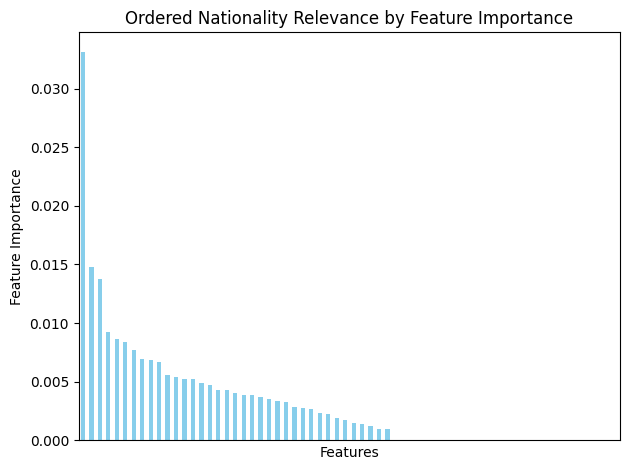

In [ ]:
# Filter only the nationality columns for relevance
nationality_columns = [col for col in features if 'Nationality_' in col]
nationality_importance_df = importance_df[importance_df['Features'].isin(nationality_columns)]

# Sort by importance in descending order
nationality_importance_df = nationality_importance_df.sort_values(by='Importance', ascending=False)

# Plot the ordered relevance of nationalities without displaying the nationality names
plt.figure(figsize=(12, 8))
nationality_importance_df.plot(kind='bar', x='Features', y='Importance', legend=False, color='skyblue')

plt.xticks([])

plt.title('Ordered Nationality Relevance by Feature Importance')
plt.ylabel('Feature Importance')

plt.tight_layout()
plt.show()

In [ ]:
threshold_club = 0.005
threshold_nat = 0.006

In [ ]:
# Keep only important clubs and group irrelevant clubs into 'Club_Other'
important_clubs = club_importance_df[club_importance_df['Importance'] >= threshold_club]['Features'].values
print(important_clubs)

# Sum the non-important club columns into 'Club_Other'
X['Club_Other'] = X[club_columns].loc[:, ~X[club_columns].columns.isin(important_clubs)].sum(axis=1)

# Keep the original non-club columns along with important clubs and 'Club_Other'
non_club_columns = [col for col in X.columns if col not in club_columns]
X = X[non_club_columns + important_clubs.tolist()]


['Club_Real Madrid' 'Club_Manchester City' 'Club_FC Barcelona'
 'Club_Paris Saint-Germain' 'Club_Bayern Munich' 'Club_Liverpool FC'
 'Club_Arsenal FC' 'Club_Manchester United' 'Club_Chelsea FC'
 'Club_Stade Rennais FC' 'Club_Brentford FC' 'Club_Sporting CP'
 'Club_Juventus FC' 'Club_AC Milan' 'Club_Tottenham Hotspur'
 'Club_SSC Napoli' 'Club_Inter Milan' 'Club_Bayer 04 Leverkusen']


In [ ]:
# Get the important nationality columns based on the feature importance
important_nationalities = nationality_importance_df[nationality_importance_df['Importance'] >= threshold_nat]['Features'].values
print(important_nationalities)

# Sum the non-important nationality columns into 'Nationality_Other'
X['Nationality_Other'] = X[nationality_columns].loc[:, ~X[nationality_columns].columns.isin(important_nationalities)].sum(axis=1)

# Keep the original non-nationality columns along with important nationalities and 'Nationality_Other'
non_nationality_columns = [col for col in X.columns if col not in nationality_columns]
X = X[non_nationality_columns + important_nationalities.tolist()]

['Nationality_St. Kitts & Nevis' 'Nationality_Ireland'
 'Nationality_Ukraine' 'Nationality_Germany' 'Nationality_Türkiye'
 'Nationality_Netherlands' 'Nationality_Cameroon' 'Nationality_Belgium'
 'Nationality_England' 'Nationality_Egypt']


In [ ]:
club_df = X.copy()
club_df['Market_Value_normalizada'] = y
club_df['Market Value'] = df['Market Value']
club_df['Player'] = df['Player']
club_df['Season'] = df['Season']
club_df.head()

,ID,Age,days_injured,injuries,games_missed,appearances,own_goals,assists,substitutions_on,substitutions_off,...,Nationality_Türkiye,Nationality_Netherlands,Nationality_Cameroon,Nationality_Belgium,Nationality_England,Nationality_Egypt,Market_Value_normalizada,Market Value,Player,Season
0,398073,17,0,0,0,34.0,0.0,10.0,2.0,2.0,...,0,0,0,0,0,0,0.00125,250000.0,Achraf Hakimi,16/17
1,398073,19,0,0,0,17.0,0.0,1.0,3.0,3.0,...,0,0,0,0,0,0,0.02500,5000000.0,Achraf Hakimi,17/18
2,398073,19,66,1,7,28.0,0.0,7.0,3.0,2.0,...,0,0,0,0,0,0,0.09625,19250000.0,Achraf Hakimi,18/19
3,398073,21,0,0,0,45.0,0.0,10.0,7.0,7.0,...,0,0,0,0,0,0,0.26500,53000000.0,Achraf Hakimi,19/20
4,398073,21,5,2,3,45.0,1.0,11.0,11.0,13.0,...,0,0,0,0,0,0,0.25000,50000000.0,Achraf Hakimi,20/21


In [ ]:
club_df.to_csv('reduced_df.csv', index=False)

In [ ]:
xgb_model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_child_weight': [5, 10],
    'lambda': [0.1, 1, 10],
    'alpha': [0.1, 1, 10],
    'colsample_bytree': [0.8, 1.0]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Negative RMSE for minimization
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Extract the best parameters and score
best_params = grid_search.best_params_

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_xgb = r2_score(y_test, y_pred_best)

print("Best Parameters:", best_params)
print("Test Set RMSE:", rmse_xgb)
print("Test Set R²:", r2_xgb)

Fitting 3 folds for each of 864 candidates, totalling 2592 fits
Best Parameters: {'alpha': 0.1, 'colsample_bytree': 0.8, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 1000, 'subsample': 0.8}
Test Set RMSE: 0.07682856647273595
Test Set R²: 0.7205786034888451


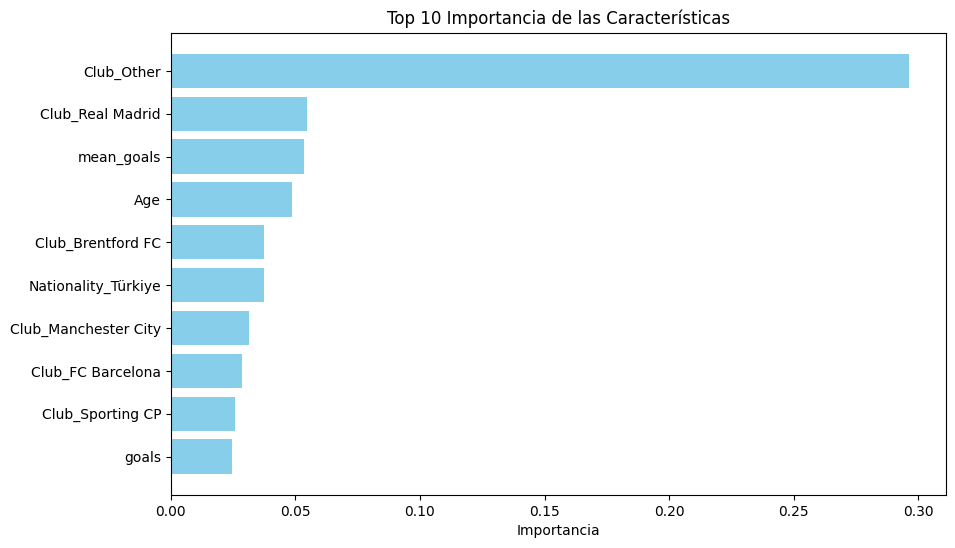

In [ ]:
plot_feature_importances(best_model)

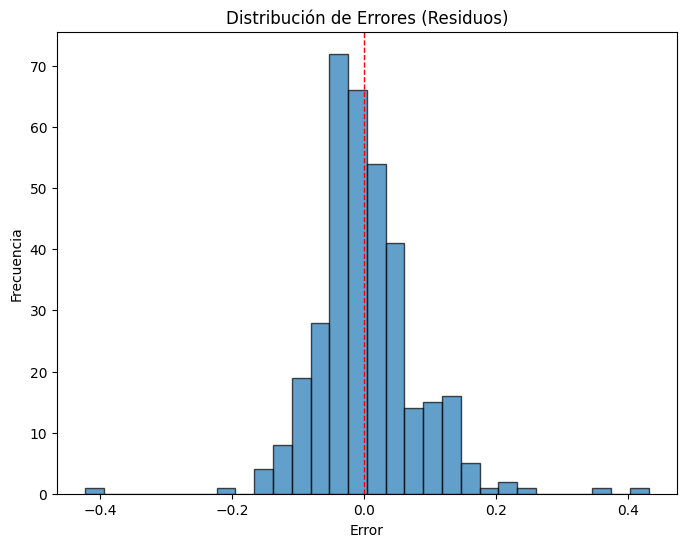

In [ ]:
plot_residuals(y_test, y_pred_best)

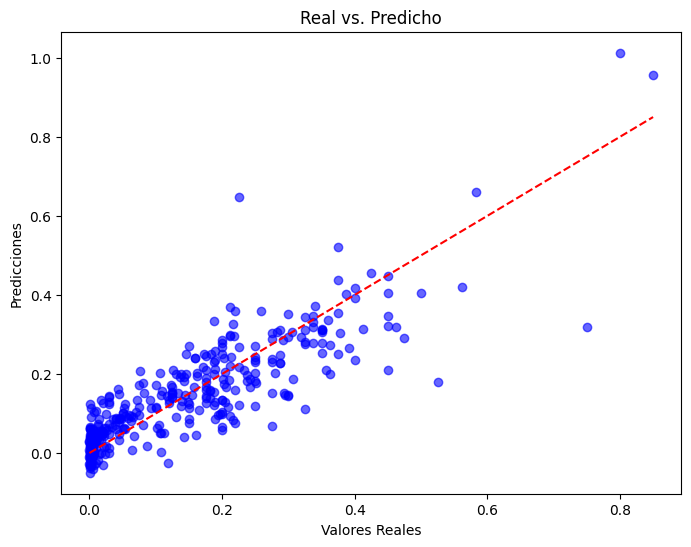

In [ ]:
plot_real_vs_pred(y_test, y_pred_best)

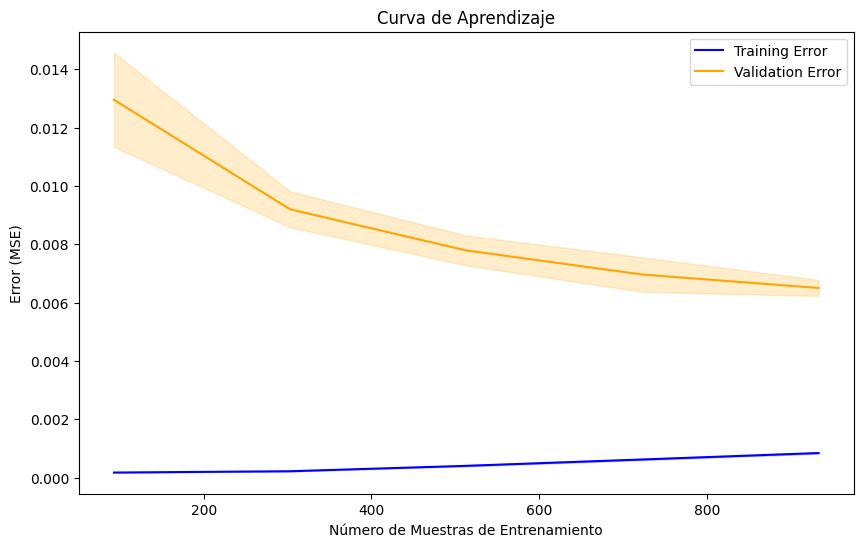

In [ ]:
plot_learning_curve(best_model, X_train)

In [ ]:
rf_red_model = best_model
joblib.dump(rf_red_model, 'xgb_red_model.pkl')

['xgb_red_model.pkl']